In [1]:
import os
import numpy as np
import math
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, njit, vectorize, cuda,float64,int32

## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [2]:
A=[2,5,10,3,8]
@vectorize([float64(float64)], target='parallel', fastmath=True)
def exp(x):
    return np.exp(x)

@vectorize([float64(float64)], target='parallel', fastmath=True)
def log(x):
    return np.log(x)


print(log(A))
print(exp(A))

[0.69314718 1.60943791 2.30258509 1.09861229 2.07944154]
[7.38905610e+00 1.48413159e+02 2.20264658e+04 2.00855369e+01
 2.98095799e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [3]:
A=np.linspace(-3,3,100000)

@vectorize([float64(float64,float64,float64)], target='parallel', fastmath=True) 
def gauss_pdf(x,mu,sigma):
    return np.exp(-0.5*((x-mu)/sigma)**2)/(sigma*np.sqrt(2*np.pi))

print(gauss_pdf(A,1,1))

[0.00013383 0.00013386 0.00013389 ... 0.05400393 0.05399745 0.05399097]


## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

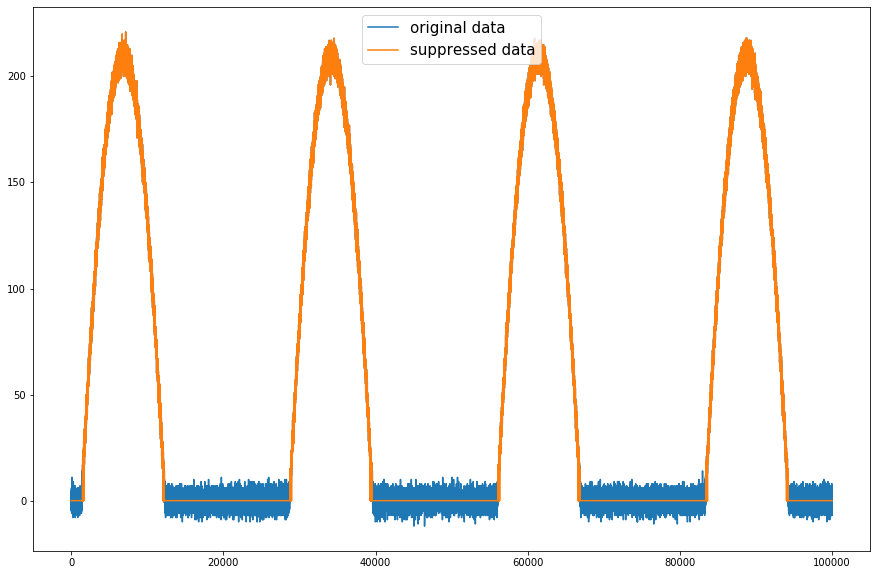

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

@vectorize([float64(float64,int32)])
def zero_suppression(data,threshold):
    if data<threshold: return 0
    else: return data
    
fig=plt.figure(figsize=(15,10))
suppressed_data=zero_suppression(data,15)
plt.plot(data,label='original data')

plt.plot(suppressed_data,label='suppressed data')
plt.legend(loc='upper center',fontsize=15);

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [5]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

@jit(float64[:,:](float64[:,:], float64[:,:], float64, float64), fastmath=True)
def sigmoid_kernel(x, y, alpha, c):
    x_rows, x_cols = x.shape
    y_rows, y_cols = y.shape
    k = np.zeros((x_cols, y_cols))
    for k_rows in range(x_cols):
        for k_cols in range(y_cols):
            temp = 0
            for i in range(x_rows):
                temp += x[i,k_rows]*y[i,k_cols]
            k[k_rows,k_cols] = np.tanh(alpha*temp + c) 
    return k


alpha=0.5
c=1
print("Sigmoid Kernel:",sigmoid_kernel(X, Y, alpha, c))


Sigmoid Kernel: [[0.8612116  0.91419357 0.9025312 ]
 [0.88210041 0.93309072 0.92818482]
 [0.83152493 0.88178273 0.86543887]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [ ]:
@cuda.jit
def double_kernel(io_array):
    i,j,k = cuda.grid(3)
    if i < io_array.shape[0] and j < io_array.shape[1] and k < io_array.shape[2]:
        io_array[i][j][k] = np.cos(io_array[i][j][k]) 

X = np.random.rand(256,256,256)        

threadsperblock = (16,8,2) #ThreadsPerBlock must be a divisor of the data dimension
blockspergrid_x = int(math.ceil(X.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(X.shape[1] / threadsperblock[1]))
blockspergrid_z = int(math.ceil(X.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

double_kernel[blockspergrid, threadsperblock](X)

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [6]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp
        

# Initialize the data arrays
A = np.random.randint(0,50,size=(24, 12))
B = np.random.randint(0,50,size=(12, 22))
C = np.zeros((24, 22), dtype=int)

# Configure the blocks
threadsperblock = (16, 16)
blockspergrid_x = int(np.ceil(C.shape[0] / threadsperblock[0]))
blockspergrid_y = int(np.ceil(C.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y) 

matmul[blockspergrid, threadsperblock](A, B, C)
print("AB - C = ", np.dot(A, B) - C)

AB - C =  [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0